# notebooks.parameterized_grover_state_preparation

In [1]:
import os
os.chdir('generative_models_via_sqsp')

In [2]:
from utilities.grover_state_preparation import *
from utilities.auxiliaries import *
from config import *

In [3]:
import numpy as np
from scipy.stats import beta, chisquare, entropy, wasserstein_distance
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile

In [4]:
alpha = 2
beta_ = 2
a = 0
b = 1
num_runs = 10
opt_indices = [2**m-3, 2**m-2]

In [5]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m-1), alpha, beta_)
p_i_set /= p_i_set.sum()

In [6]:
initial_thetas = np.array(generate_parameters(2**m-1, k=2))
thetas = get_grover_angles(p_i_set, m)
qc = state_expansion(m, thetas)
t_qc = transpile(qc, backend=backend)
job = backend.run(t_qc, shots=shots)
counts = job.result().get_counts(qc)
exp_distribution = np.array([counts.get(state, 0) for state in all_states], dtype=float)
if exp_distribution.sum() > 0:
    exp_distribution /= exp_distribution.sum()
else:
    exp_distribution = np.zeros_like(exp_distribution)

In [7]:
loss = [compute_loss(exp_distribution, p_i_set, loss_type="mmd")]
extra_angles = []
samples_all = []
loss_history = []
best_loss = float('inf')
best_thetas = None
best_distribution = None
for run in range(num_runs):
    initial_opt_thetas = initial_thetas[opt_indices]
    result = minimize(compute_loss_partial, initial_opt_thetas,
                      args=(initial_thetas, opt_indices, p_i_set),
                      method=optimizer_type, options={"disp": False, "maxiter": max_iterations})
    current_loss = result.fun
    updated_thetas = initial_thetas.copy()
    for i, idx in enumerate(opt_indices):
        updated_thetas[idx] = result.x[i]
    qc_best = state_expansion(m, list(updated_thetas))
    t_qc_best = transpile(qc_best, backend=backend)
    job_best = backend.run(t_qc_best, shots=shots)
    counts_best = job_best.result().get_counts(qc_best)
    exp_distribution = np.array([counts_best.get(state, 0) for state in all_states], dtype=float)
    if exp_distribution.sum() > 0:
        exp_distribution /= exp_distribution.sum()
    loss_history.append(current_loss)
    if current_loss < best_loss:
        best_loss = current_loss
        best_thetas = updated_thetas.copy()
        best_distribution = exp_distribution

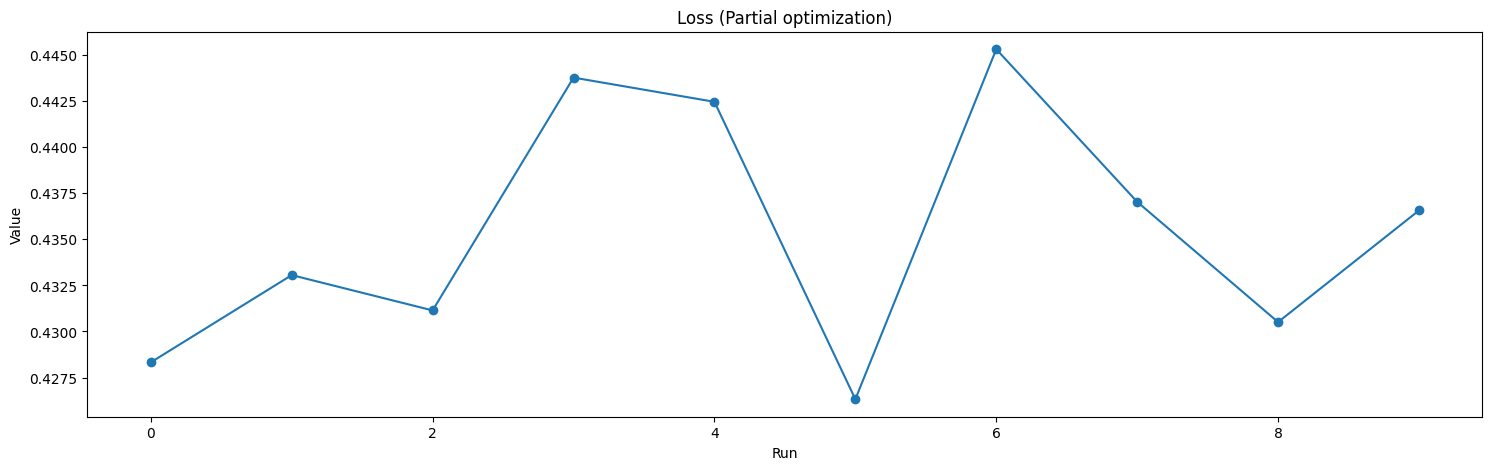

In [8]:
plt.figure(figsize=(18, 5))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Run")
plt.ylabel("Value")
plt.title("Loss (Partial optimization)")
plt.show()

In [11]:
exp_distribution = np.array(exp_distribution)
p_target = np.array(p_i_set)
if len(p_i_set) > len(exp_distribution):
    p_i_set = p_i_set[:len(exp_distribution)]
elif len(p_i_set) < len(exp_distribution):
    exp_distribution = exp_distribution[:len(p_i_set)]

chi_stat, chi_p = chisquare(exp_distribution, f_exp=p_i_set)
kl_div = entropy(exp_distribution, p_i_set[:len(exp_distribution)])
emd = wasserstein_distance(exp_distribution, p_i_set[:len(exp_distribution)])
print(f"Chi-Square Test: statistic={chi_stat}, p-value={chi_p}")
print(f"KL Divergence: {kl_div}")
print(f"Earth Mover's Distance: {emd}")

Chi-Square Test: statistic=inf, p-value=0.0
KL Divergence: inf
Earth Mover's Distance: 0.06451469658489452


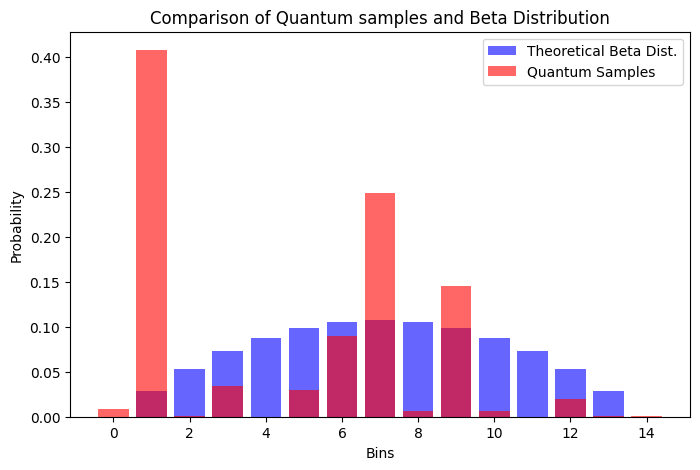

In [12]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
plt.bar(range(len(exp_distribution)), exp_distribution, alpha=0.6, label='Quantum Samples', color='red')
plt.xlabel("Bins")
plt.ylabel("Probability")
plt.legend()
plt.title("Comparison of Quantum samples and Beta Distribution")
plt.show()